In [202]:
%matplotlib inline

In [1]:
# # -----------------------------
# #  Install necessary packages (based on Python>3.8)
# # -----------------------------
!pip install botorch
!pip install gpytorch
!pip install scipy
!pip install -U scikit-learn
!pip install h5py


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.8/644.8 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.8/277.8 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.4/176.4 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 54.4 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.5.2
    Uninstalling scikit-learn-1.5.2:
      Successfully uninstalled scikit-learn-1.5.2


In [2]:
# -----------------------------
#  Load all libraries required.
# -----------------------------
import torch
import gpytorch

from botorch.models import SingleTaskMultiFidelityGP
from botorch.acquisition.analytic import ExpectedImprovement

from botorch.models.transforms.outcome import Standardize
from gpytorch.mlls import ExactMarginalLogLikelihood
# from botorch import fit_gpytorch_model OLD!!!!
from botorch import fit_gpytorch_mll
from sklearn.ensemble import RandomForestRegressor


from scipy.stats import norm
import numpy as np
import pandas as pd
import pickle
import h5py # for .jld2 files
import os
import time

import matplotlib.pyplot as plt

from sklearn.metrics import r2_score, mean_absolute_error
# -----------------------------
#  figure settings
# -----------------------------
!pip install seaborn
import seaborn as sns
sns.set(style='ticks', palette='Set2', font_scale=1.5, rc={"lines.linewidth": 3})
sns.despine()
# plt.rcParams.update({'font.size': 16})
# plt.rcParams['figure.dpi'] = 1200 # 600-1200 for paper quality

# save_figures = True
discrete_fidelities = [1/3, 2/3] # set of discrete fidelities (in ascending order) to select from this cannot be changed.
ablation_study_flag = False # make features have no information for a baseline. to gauge feature importance
from google.colab import files
uploaded = files.upload()
import pandas as pd
file = file = pd.read_excel('solvents_t1.xlsx')
feature_names = list(file.columns[:-1])

Saving solvents_t1.xlsx to solvents_t1.xlsx


<Figure size 640x480 with 0 Axes>

In [3]:
# feature matrix in torch tensor
X = torch.from_numpy(np.array(file.iloc[:,1:8]))

if ablation_study_flag:
    # suffle columns
    for j in range(X.size()[1]):
        shuffled_row_ids - torch.randper(X.size()[0])
        X[:, j] = X[shuffled_row_ids, j]

# simulation data
y = [torch.from_numpy(np.array(file["lnk_MLR"])),
     torch.from_numpy(np.array(file["lnk_QM"][:]))]

print("=====Top solvent is====")
p1 = file[file["lnk_QM"] == file["lnk_QM"].max()]["Solvent"].iloc[0]
p2 = file[file["lnk_QM"] == file["lnk_QM"].max()]["lnk_QM"].iloc[0]
print("The best sovlent found is {} and its lnk_QM value is {}".format(p1,p2))
print("=======================")

# associated simulation costs
cost = [np.transpose(np.array(file["MLR_total_eleapsed_time"][:])),       # [min]
        np.transpose(np.array(file["QM_total_eleapsed_time"][:]))]        # [min]

# total number of solvents (SOLs) in data set
nb_SOLs = X.shape[0]

=====Top solvent is====
The best sovlent found is solvent326 and its lnk_QM value is -5.9


In [4]:
# The first 9 solvents are our baseline that will be used for the initialisation of BO
file.head(9)

,Solvent,n_square,A,B,Gamma,Epsilon,Aromaticity,Halogenicity,lnk_QM,lnk_MLR,QM_total_eleapsed_time,MLR_total_eleapsed_time
0,benzene,2.253,0.00,0.14,0.406,0.023,1.00,0.0,-13.57,-13.362639,531,1.0
1,carbon_tetrachloride,2.132,0.00,0.00,0.380,0.022,0.00,0.8,-13.78,-13.777061,422,2.8
2,m-cresol,2.383,0.57,0.34,0.514,0.124,0.75,0.0,-7.46,-7.732429,544,2.5
3,diiodomethane,3.036,0.05,0.23,0.953,0.053,0.00,0.0,-8.86,-8.779461,354,0.8
4,N-methylformamide,2.050,0.40,0.55,0.554,1.816,0.00,0.0,-5.92,-5.942537,580,2.0
5,n-pentane,1.843,0.00,0.00,0.223,0.018,0.00,0.0,-14.91,-15.063605,549,2.3
6,tetrahydrothiophene-S_S-dioxide,2.200,0.00,0.88,0.875,0.440,0.00,0.0,-6.23,-6.347587,372,2.4
7,tributylphosphate,2.023,0.00,1.21,0.276,0.082,0.00,0.0,-9.04,-8.977825,669,3.2
8,formic_acid,1.881,0.75,0.38,0.534,0.511,0.00,0.0,-5.99,-5.775926,411,1.0


In [5]:
nb_solvent = 9           # The number of solvents in the initial set
nb_runs = 50             # Total budget, i.e., the number of iteration
num_features = len(X[0]) # Number of feature

init_sol_ids = np.array(range(0,nb_solvent))
# Print the solvent features (X)
for i, f in enumerate(feature_names):
    if (i>0) & (i<num_features+1):
        print("{}: {}".format(i, f))
for j in range(X.size()[1]):
    X[:, j] = (X[:, j] - torch.min(X[:, j]).item()) / (torch.max(X[:, j]).item() - torch.min(X[:, j]).item())

# normalization worked
assert np.allclose(torch.min(X, 0).values, torch.zeros(num_features))
assert np.allclose(torch.max(X, 0).values, torch.ones(num_features))
# cost
print("total high-fidelity cost   :", sum(cost[1]).item(), "[min]")
print("total low-fidelity cost    :", sum(cost[0]).item(), "[min]")
print("average high-fidelity cost :", np.mean(cost[1]), "[min]")
print("average low-fidelity cost  :", np.mean(cost[0]), "[min]")
print("average cost ratio         :", np.mean(cost[1] / cost[0]))

# data shape
print("\nraw data - \n\tX:", X.shape)
for f in range(2):
    print("\tfidelity:", f)
    print("\t\ty:", y[f].shape)
    print("\t\tcost: ", cost[f].shape)

# normalization check
print("\nEnsure features are normalized - ")
print("max:\n", torch.max(X, 0).values)
print("min:\n", torch.min(X, 0).values)
print("width:\n",torch.max(X, 0).values - torch.min(X, 0).values)
print("mean:\n", torch.mean(X, 0))
print("std:\n", torch.std(X, 0))

1: n_square
2: A
3: B
4: Gamma
5: Epsilon
6: Aromaticity
7: Halogenicity
total high-fidelity cost   : 167285 [min]
total low-fidelity cost    : 748.3000000000003 [min]
average high-fidelity cost : 499.35820895522386 [min]
average low-fidelity cost  : 2.233731343283582 [min]
average cost ratio         : 313.2549525806738

raw data - 
	X: torch.Size([335, 7])
	fidelity: 0
		y: torch.Size([335])
		cost:  (335,)
	fidelity: 1
		y: torch.Size([335])
		cost:  (335,)

Ensure features are normalized - 
max:
 tensor([1., 1., 1., 1., 1., 1., 1.], dtype=torch.float64)
min:
 tensor([0., 0., 0., 0., 0., 0., 0.], dtype=torch.float64)
width:
 tensor([1., 1., 1., 1., 1., 1., 1.], dtype=torch.float64)
mean:
 tensor([0.4042, 0.1540, 0.3370, 0.3222, 0.0658, 0.0590, 0.0092],
       dtype=torch.float64)
std:
 tensor([0.0887, 0.2108, 0.1510, 0.1425, 0.0803, 0.1967, 0.0777],
       dtype=torch.float64)


In [6]:
# return list of fidelity id's (0's and 1's) from the acquired set.
def get_f_ids(acquired_set):
    if acquired_set.dim() == 0:
        return acquired_set.round().to(dtype=int)
    else:
        f_ids = [a[0].round().to(dtype=int) for a in acquired_set]
        return torch.tensor(f_ids)
# get the list of high-fidelity y_max's from iter-to-iter
# returns an array.
# element i is best y-max high fidelity seen up to iteration i.
def get_y_maxes_hf_acquired(acquired_set):
    nb_iters = len(acquired_set)
    y_maxes = np.zeros(nb_iters)
    # we want the maximum y value (only high-fidelity) up to a given iteration
    y_max = 0.0 # update this each iteration.
    for i, (f_val, cof_id) in enumerate(acquired_set):
        f_id = get_f_ids(torch.tensor(f_val))
        assert f_id in [0, 1]
        y_acq_this_iter = y[f_id][int(cof_id)]
        # i is iteration index
        if f_id == 1 and y_acq_this_iter > y_max:
            y_max = y_acq_this_iter # over-write max
        y_maxes[i] = y_max
    return y_maxes
# find accumulated cost, given acquired set.
# returns an array.
# element i is cost accumulated till iteration i
def accumulated_cost(acquired_set):
    nb_iters = len(acquired_set)
    accumulated_cost = np.zeros(nb_iters)
    for i, (f_val, cof_id) in enumerate(acquired_set):
        cof_id = int(cof_id.item())
        f_id = f_val.round().to(dtype=int).item()
        if i == 0:
            accumulated_cost[i] = cost[f_id][cof_id]
        else:
            accumulated_cost[i] = accumulated_cost[i-1] + cost[f_id][cof_id]
    return accumulated_cost
# calcualte the fraction of sims up to that point that are a given fidelity
# entry i is fraction of sims up to that point that are fidelity fidelity.
def calc_fidelity_fraction(acquired_set, fidelity):
    assert fidelity in [1/3, 2/3]
    nb_iters = len(acquired_set)
    fid_frac = np.zeros(nb_iters)
    for i in range(nb_iters):
        fid_frac[i] = sum(acquired_set[:, 0][:i+1] == fidelity) / (i+1)
    return fid_frac
def initialize_acquired_set(initializing_SOLs, discrete_fidelities):
    return torch.tensor([[f_id, sol_id] for sol_id in initializing_SOLs for f_id in discrete_fidelities])
# construct feature matrix of acquired points.
# the last entry is the fidelity parameter.
def build_X_train(acquired_set):
    cof_ids = [a[1].to(dtype=int) for a in acquired_set]
    f_ids = torch.tensor([a[0] for a in acquired_set])
    assert f_ids[0] in [1/3, 2/3]
    return torch.cat((X[cof_ids, :], f_ids.unsqueeze(dim=-1)), dim=1)

# construct output vector for acquired points
def build_y_train(acquired_set):
    f_ids = get_f_ids(acquired_set)
    cof_ids = [a[1].to(dtype=int) for a in acquired_set] # this is where the "experiment" is conducted
    return torch.tensor([y[f_id][cof_id] for f_id, cof_id in zip(f_ids, cof_ids)]).unsqueeze(-1)
# construct vector to track cost of acquired points
# entry i is cost of acquired Solvent i
def build_cost(acquired_set):
    f_ids = get_f_ids(acquired_set)
    cof_ids = [a[1].to(dtype=int) for a in acquired_set]
    return torch.tensor([cost[f_id][cof_id] for f_id, cof_id in zip(f_ids, cof_ids)]).unsqueeze(-1)

# construct vector to track cost of acquired points
# entry i is cost of acquired COF i within a given fidelity_id
def build_cost_fidelity(acquired_set, fidelity_id):
    assert fidelity_id in [0, 1]
    f_ids = get_f_ids(acquired_set)
    cof_ids = [a[1].to(dtype=int) for a in acquired_set]
    return torch.tensor([cost[f_id][cof_id] for f_id, cof_id in zip(f_ids, cof_ids) if f_id == fidelity_id]).unsqueeze(-1)
import torch
from gpytorch.kernels import Kernel

class LinearDistanceKernel(Kernel):
    """
    formula for kernel:
    k(x1, x2)=1-|x1 - x2|
    """
    def __init__(self,**kwargs):
        super(LinearDistanceKernel, self).__init__(**kwargs)
    def forward(self, x1, x2, **params):
        #compute distance between inputs
        distance = torch.cdist(x1, x2, p=1)
        #ensure kernel is also positive
        kernel = 1 - distance
        #clip the values to maintain numerical stability
        kernel = torch.clamp(kernel, min=0.0)

        return kernel
#checking package is installed for kernels:
import gpytorch
from gpytorch.models import ExactGP
from gpytorch.means import ConstantMean
from gpytorch.kernels import RBFKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood
class CustomMultiFidelityGP(ExactGP):
    def __init__(self, train_X, train_Y, likelihood):
        super().__init__(train_X, train_Y.squeeze(-1), likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        # RBF for feature kernel
        self.feature_kernel = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        # Linear kernel for fidelity
        self.fidelity_kernel = LinearDistanceKernel()

    def transform_inputs(self, X):
        # If you need a custom transformation or splitting logic,
        # you can implement it here. For now, return X as is.
        return X

    def forward(self, X):
        # Use transform_inputs if needed, e.g.:
        X_transformed = self.transform_inputs(X)

        X_features = X_transformed[:, :-1]
        X_fidelity = X_transformed[:, -1:]
        covar_feature = self.feature_kernel(X_features)
        covar_fidelity = self.fidelity_kernel(X_fidelity, X_fidelity)
        covar_x = covar_feature * covar_fidelity
        mean_x = self.mean_module(X_transformed)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

    def posterior(self, X_new):
        self.eval()
        with torch.no_grad():
            return self.likelihood(self(X_new))
#checking pacakages...
import torch
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood

def train_surrogate_model(X_train, y_train):
    # Ensure y_train is a 2D tensor
    if y_train.dim() == 1:
        y_train = y_train.unsqueeze(-1)  # shape should be (n, 1)

    likelihood = GaussianLikelihood()
    # Build model with the custom GP
    model = CustomMultiFidelityGP(train_X=X_train, train_Y=y_train, likelihood=likelihood)

    model.train()
    likelihood.train()

    # Marginal log likelihood
    mll = ExactMarginalLogLikelihood(likelihood, model)

    # Define the optimizer (Adam)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

    # For tracking the best Y found so far
    best_values = []
    best_y = y_train.max().item()  # Initialize with the best known from the initial data

    # Training loop
    num_iterations = 100
    for i in range(num_iterations):
        optimizer.zero_grad()
        output = model(X_train)
        loss = -mll(output, y_train).sum()  # Ensure scalar loss
        loss.backward()
        optimizer.step()

        # Update and track best_y after each iteration
        # You might want to use model posterior if you are doing something else,
        # but here we simply track the best training point's Y for demonstration.
        current_best = y_train.max().item()
        if current_best > best_y:
            best_y = current_best
        best_values.append(best_y)

        if i % 10 == 0:
            print(f"Iteration {i + 1}/{num_iterations}: Loss = {loss.item():.4f}, Best Y = {best_y:.4f}")

    return model
def mu_sigma(model, X, fidelity):
    assert fidelity in [1/3, 2/3]
    nb_SOLs_here = X.size()[0]
    f = torch.tensor((), dtype=torch.float64).new_ones((nb_SOLs_here, 1)) * fidelity
    X_f = torch.cat((X, f), dim=1)  # Combine X with fidelity values
    f_posterior = model.posterior(X_f)  # Get the posterior
    return f_posterior.mean.squeeze().detach().numpy(), np.sqrt(f_posterior.variance.squeeze().detach().numpy())
# ratio of mean cost of sims of high fidelity to those of fidelity-fidelity, within acquired set so far.
def estimate_cost_ratio(acquired_set, fidelity):
    assert fidelity in [1/3, 2/3]
    f_id = get_f_ids(torch.tensor(fidelity))
    avg_cost_f  = torch.mean(build_cost_fidelity(acquired_set, f_id).float())
    avg_cost_hf = torch.mean(build_cost_fidelity(acquired_set, 1).float())
    cr = avg_cost_hf / avg_cost_f
    return cr.item()
# get the current best y-value of desired_fidelity in the acquired set
def get_y_max(acquired_set, fidelity):
    assert fidelity in [0, 1]
    f_ids = get_f_ids(acquired_set)
    cof_ids = [a[1].to(dtype=int) for a in acquired_set]
    return np.max([y[f_id][cof_id] for f_id, cof_id in zip(f_ids, cof_ids) if f_id == fidelity])
###
#  efficient multi-fidelity correlation function
#  corr(y at given fidelity, y at high-fidelity)
#  (see notes)
#  This is the second term in the AugEI acquisition function
###
def mfbo_correlation_function(model, X, fidelity):
    assert fidelity in [1/3, 2/3]
    # given fidelity
    f   = torch.tensor((), dtype=torch.float64).new_ones((nb_SOLs, 1)) * fidelity
    X_f = torch.cat((X, f), dim=1) # last col is associated fidelity
    #high fidelity
    hf   = torch.tensor((), dtype=torch.float64).new_ones((nb_SOLs, 1)) * discrete_fidelities[-1]
    X_hf = torch.cat((X, hf), dim=1) # last col is associated fidelity
    # combine into a single tensor
    X_all_fid = torch.cat((X_f, X_hf), dim=0)

    # get variance for each fidelity
    var_f = torch.flatten(model.posterior(X_f).variance)
    var_hf = torch.flatten(model.posterior(X_hf).variance) # variance

    # posterior covariance
    cov = torch.diag(model(X_all_fid).covariance_matrix[:X_f.size()[0], X_f.size()[0]:])

    corr = cov / (torch.sqrt(var_f) * torch.sqrt(var_hf))
    return corr
###
#  expected imrovement function, only uses hf
#  we have a GP for the high fidelity and for the low fidelity
#  we only consult the high fidelity GP
###
def EI_hf(model, X, acquired_set):
    '''
    This function returns a vector of length X
    The acquired set is the observed set
    The function assigns an EI value to each solvent in X
    '''
    hf_mu, hf_sigma = mu_sigma(model, X, discrete_fidelities[-1]) # hf_mu and hf_sigma are vectors of length 335 (each solvent that was not in the initial set)
    y_max = get_y_max(acquired_set, 1)

    z = (hf_mu - y_max) / hf_sigma
    explore_term = hf_sigma * norm.pdf(z)
    exploit_term = (hf_mu - y_max) * norm.cdf(z)
    ei = explore_term + exploit_term
    return np.maximum(ei, np.zeros(X.size()[0]))

###
#  acquisition function combining the three terms (EI, Corr, CostRatio)
###
def acquisition_scores(model, X, fidelity, acquired_set):
    assert fidelity in [1/3, 2/3]
    # expected improvement for high-fidelity
    ei = EI_hf(model, X, acquired_set)

    # augmenting functions
    corr_f1_f0 = mfbo_correlation_function(model, X, fidelity)

    cr = estimate_cost_ratio(acquired_set, fidelity)

    scores = torch.from_numpy(ei) * corr_f1_f0 * cr
    return scores.detach().numpy()
# return True if (f_id, cof_id) in acquired set and False otherwise
def in_acquired_set(f_id, cof_id, acquired_set):
    assert f_id in [0, 1]
    fidelity = discrete_fidelities[f_id]
    for this_fidelity, this_cof_id in acquired_set:
        if this_cof_id == cof_id and this_fidelity == fidelity:
            return True
    return False
###
#  expected imrovement function, only uses hf
#  we have a GP for the high fidelity and for the low fidelity
#  we only consult the high fidelity GP
###
def EI_hf(model, X, acquired_set):
    '''
    This function returns a vector of length X
    The acquired set is the observed set
    The function assigns an EI value to each solvent in X
    '''
    hf_mu, hf_sigma = mu_sigma(model, X, discrete_fidelities[-1]) # hf_mu and hf_sigma are vectors of length 335 (each solvent that was not in the initial set)
    y_max = get_y_max(acquired_set, 1)

    z = (hf_mu - y_max) / hf_sigma
    explore_term = hf_sigma * norm.pdf(z)
    exploit_term = (hf_mu - y_max) * norm.cdf(z)
    ei = explore_term + exploit_term
    return np.maximum(ei, np.zeros(X.size()[0]))

###
#  acquisition function combining the three terms (EI, Corr, CostRatio)
###
def acquisition_scores(model, X, fidelity, acquired_set):
    assert fidelity in [1/3, 2/3]
    # expected improvement for high-fidelity
    ei = EI_hf(model, X, acquired_set)

    # augmenting functions
    corr_f1_f0 = mfbo_correlation_function(model, X, fidelity)

    cr = estimate_cost_ratio(acquired_set, fidelity)

    scores = torch.from_numpy(ei) * corr_f1_f0 * cr
    return scores.detach().numpy()


In [7]:
def run_Bayesian_optimization(nb_iterations, initializing_SOLs, verbose=False, stop_after_top_acquired=True):
    assert nb_iterations > len(initializing_SOLs)

    ###
    #  initialize acquired set
    ###
    acquired_set = initialize_acquired_set(initializing_SOLs, discrete_fidelities)

    # the initial acquired set is a 18x2 vector with fidelities (0.3 and 0.6) and solvent ID (0 to 8, one for each fidelity level)

    for i in range(len(initializing_SOLs), nb_iterations):
        #print("BO iteration: ", i)
        ###
        #  construct training data (perform experiments)
        ###
        X_train = build_X_train(acquired_set)

        # the initial training set is an 18x8 matrix with columns 1-7: features 1: n_square 2: A 3: B 4: Gamma 5: Epsilon 6: Aromaticity 7: Halogenicity and column 8 as fidelity (0.3, 0.6) (again, each row doubles and has either 0.3 or 0.6 in the end)

        y_train = build_y_train(acquired_set)

        # y_train is the non-normalized versions with solvatochromic logk and qm logk in alternating rows (meaning 2 rows for each solvent), again the initial set is an 18x1 matrix

        if verbose:
            print("Initialization - \n")
            print("\tSOL IDs acquired    = ", [acq_[1].item() for acq_ in acquired_set])
            print("\tfidelities acquired = ", [acq_[0].item() for acq_ in acquired_set])
            print("\tcosts acquired      = ", build_cost(acquired_set), " [min]")

            print("\n\tTraining data:\n")
            print("\t\t X train shape = ", X_train.shape)
            print("\t\t y train shape = ", y_train.shape)
            print("\t\t training feature vector = \n", X_train)

        ###
        #  train Model (maximize mll)
        ###



        model = train_surrogate_model(X_train, y_train)

        ###
        #  acquire new (SOL, fidelity) not yet acquired.
        ###
        # entry (fid_id, sol_id) is the acquisition value for fidelity f_id and cof sol_id
        the_acquisition_scores = np.array([acquisition_scores(model, X, fidelity, acquired_set) for fidelity in discrete_fidelities])
        # in the first iteration, this function returns a vector of size 2x355 (first row low fidelity scores, second row high fidelity scores)
        # the acquisiiton scores include the high-fidelity EI x term2 x term3, whereas only term2 and term3 are dependend on the fidelity

        print(the_acquisition_scores)


        # overwrite acquired SOLs/fidelities with negative infinity to not choose these.
        for fidelity, sol_id in acquired_set:
            the_acquisition_scores[get_f_ids(fidelity), sol_id.to(dtype=int)] = - np.inf

        # in the first run, the first nine solvents are overwritten (as these were the training samples)
        # it looks like there is no difference between X and the acquired dataset, as the acquired dataset seems to be part of X

        # select SOL/fidelity with highest aquisition score.
        f_id, sol_id = np.unravel_index(np.argmax(the_acquisition_scores), np.shape(the_acquisition_scores))

        assert f_id in [0, 1]
        assert not in_acquired_set(f_id, sol_id, acquired_set)
        assert np.max(the_acquisition_scores) == the_acquisition_scores[f_id, sol_id]

        # update acquired_set
        acq = torch.tensor([[discrete_fidelities[f_id], sol_id]]) # dtype=int
        acquired_set = torch.cat((acquired_set, acq))
        # acquired set is updated and has now +1 rows. It has two columns, first one is solvent ID and second one is fidelity.
        # implicit here is that all solvents in the acquired set have had the highest acquisition score within the untested ones at one point.

        ###
        #  print useful info
        ###
        if verbose:
            print("\tacquired Solvent ", sol_id, " at fidelity, ", f_id)
            print("\t\ty = ", y[f_id][sol_id].item())
            print("\t\tcost = ", cost[f_id][sol_id])

        if stop_after_top_acquired:
            sol_id_with_max_selectivity = np.argmax(y[1])
            if sol_id_with_max_selectivity == sol_id and f_id == 1:
                print("found top Solvent! exiting.")

    return acquired_set
# ---------------------------------------------
#  construct initial inputs
# ---------------------------------------------
nb_SOLs_initialization = nb_solvent    # at each fidelity, number of SOLs to initialize with
nb_iterations = nb_runs                # BO budget, includes initializing SOLs. This is actually max # iterations

if ablation_study_flag:
    print("ablation study: {}".format(ablation_study_flag))
     # the maximum possible number iterations = num_fidelities * nb_COFs
     # this would efectively constitute a low-fidelity exhaustive search
     # followed by a high-fidelity exhaustive search

    nb_iterations = 2 * nb_SOLs
    print("max. number of iterations: {}".format(nb_iterations))

from gpytorch.kernels import RBFKernel, ScaleKernel
if not ablation_study_flag:

    # 50 iterations
    # init solvent IDs: [0 1 2 3 4 5 6 7 8]

    acquired_set = run_Bayesian_optimization(nb_iterations, init_sol_ids, verbose=False)

    ## post analysis
    #
    # unpack search results
    f_ids   = [acquired_set[i][0].item()      for i in range(len(acquired_set))]
    sol_ids = [int(acquired_set[i][1].item()) for i in range(len(acquired_set))]

    # which SOL has the largest high-fidelity reaction constant?
    sol_id_with_max_hi_fid_logk = np.argmax(y[1]).item()

    # iteration we found top SOL
    n_iter_top_sol_found = np.where([sol_ids[i] == sol_id_with_max_hi_fid_logk and f_ids[i] > 0.5 for i in range(len(sol_ids))])[0].item()
    print("iteration we acquire top SOLVENT = ", n_iter_top_sol_found)
    print("accumulated cost up to observation of top SOLVENT = ", accumulated_cost(acquired_set)[n_iter_top_sol_found], " [min]")

Streaming output truncated to the last 5000 lines.
  0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000 4.79304152e-003]]
Iteration 1/100: Loss = 224.8788, Best 

In [8]:
def run_Bayesian_optimization(nb_iterations, initializing_SOLs, verbose=False, stop_after_top_acquired=True):
    assert nb_iterations > len(initializing_SOLs)

    ###
    #  initialize acquired set
    ###
    acquired_set = initialize_acquired_set(initializing_SOLs, discrete_fidelities)

    # the initial acquired set is a 18x2 vector with fidelities (0.3 and 0.6) and solvent ID (0 to 8, one for each fidelity level)

    for i in range(len(initializing_SOLs), nb_iterations):
        #print("BO iteration: ", i)
        ###
        #  construct training data (perform experiments)
        ###
        X_train = build_X_train(acquired_set)

        # the initial training set is an 18x8 matrix with columns 1-7: features 1: n_square 2: A 3: B 4: Gamma 5: Epsilon 6: Aromaticity 7: Halogenicity and column 8 as fidelity (0.3, 0.6) (again, each row doubles and has either 0.3 or 0.6 in the end)

        y_train = build_y_train(acquired_set)

        # y_train is the non-normalized versions with solvatochromic logk and qm logk in alternating rows (meaning 2 rows for each solvent), again the initial set is an 18x1 matrix

        if verbose:
            print("Initialization - \n")
            print("\tSOL IDs acquired    = ", [acq_[1].item() for acq_ in acquired_set])
            print("\tfidelities acquired = ", [acq_[0].item() for acq_ in acquired_set])
            print("\tcosts acquired      = ", build_cost(acquired_set), " [min]")

            print("\n\tTraining data:\n")
            print("\t\t X train shape = ", X_train.shape)
            print("\t\t y train shape = ", y_train.shape)
            print("\t\t training feature vector = \n", X_train)

        ###
        #  train Model (maximize mll)
        ###



        model = train_surrogate_model(X_train, y_train)

        ###
        #  acquire new (SOL, fidelity) not yet acquired.
        ###
        # entry (fid_id, sol_id) is the acquisition value for fidelity f_id and cof sol_id
        the_acquisition_scores = np.array([acquisition_scores(model, X, fidelity, acquired_set) for fidelity in discrete_fidelities])
        # in the first iteration, this function returns a vector of size 2x355 (first row low fidelity scores, second row high fidelity scores)
        # the acquisiiton scores include the high-fidelity EI x term2 x term3, whereas only term2 and term3 are dependend on the fidelity

        print(the_acquisition_scores)


        # overwrite acquired SOLs/fidelities with negative infinity to not choose these.
        for fidelity, sol_id in acquired_set:
            the_acquisition_scores[get_f_ids(fidelity), sol_id.to(dtype=int)] = - np.inf

        # in the first run, the first nine solvents are overwritten (as these were the training samples)
        # it looks like there is no difference between X and the acquired dataset, as the acquired dataset seems to be part of X

        # select SOL/fidelity with highest aquisition score.
        f_id, sol_id = np.unravel_index(np.argmax(the_acquisition_scores), np.shape(the_acquisition_scores))

        assert f_id in [0, 1]
        assert not in_acquired_set(f_id, sol_id, acquired_set)
        assert np.max(the_acquisition_scores) == the_acquisition_scores[f_id, sol_id]

        # update acquired_set
        acq = torch.tensor([[discrete_fidelities[f_id], sol_id]]) # dtype=int
        acquired_set = torch.cat((acquired_set, acq))
        # acquired set is updated and has now +1 rows. It has two columns, first one is solvent ID and second one is fidelity.
        # implicit here is that all solvents in the acquired set have had the highest acquisition score within the untested ones at one point.

        ###
        #  print useful info
        ###
        if verbose:
            print("\tacquired Solvent ", sol_id, " at fidelity, ", f_id)
            print("\t\ty = ", y[f_id][sol_id].item())
            print("\t\tcost = ", cost[f_id][sol_id])

        if stop_after_top_acquired:
            sol_id_with_max_selectivity = np.argmax(y[1])
            if sol_id_with_max_selectivity == sol_id and f_id == 1:
                print("found top Solvent! exiting.")

    return acquired_set

In [11]:
# find SOLs that are simualted in with high- and low-fidelity.
hi_fid_sols = [sol_ids[i] for i in range(n_iter_top_sol_found) if f_ids[i] > 0.5]
lo_fid_sols = [sol_ids[i] for i in range(n_iter_top_sol_found) if f_ids[i] < 0.5]

# find SOLs simulated at both fidelities
ids_sols_hi_and_lo_fid = np.intersect1d(hi_fid_sols, lo_fid_sols)
ids_sols_hi_and_lo_fid

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

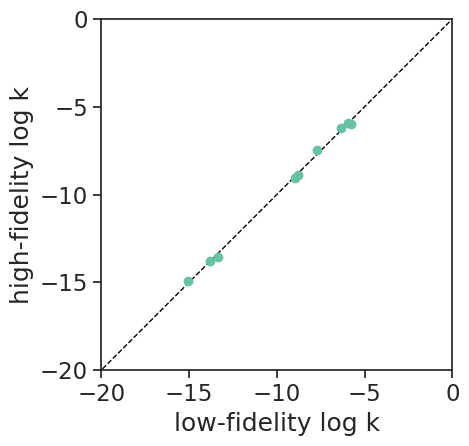

In [12]:
# build logk array for plotting,
y_los = [y[0][c].item() for c in ids_sols_hi_and_lo_fid]
y_his = [y[1][c].item() for c in ids_sols_hi_and_lo_fid]

fig = plt.figure()
plt.plot([-100, 100], [-100, 100], linestyle="--", color="k", linewidth=1)
plt.scatter(y_los, y_his, zorder=10)
ax = plt.gca()
plt.xlim(-20, 0)
plt.ylim(-20, 0)
ax.set_aspect("equal", "box")
plt.xlabel("low-fidelity log k")
plt.ylabel("high-fidelity log k")
plt.tight_layout()
plt.show()

In [13]:
# get SOL ids not in acquired set with high-fidelity sims. these are test SOLs for high-fidelity standpoint.
test_sol_ids = [sol_id for sol_id in range(nb_SOLs) if not (sol_id in hi_fid_sols)]
len(test_sol_ids)

326

In [14]:
sol_id_with_max_hi_fid_logk in test_sol_ids # the SOL with the highest logk should be in here. cuz we didn't acquire it yet.

True

In [15]:
id_in_test_sols_of_opt_sol = np.where([c == sol_id_with_max_hi_fid_logk for c in test_sol_ids])[0].item()
id_in_test_sols_of_opt_sol

325

In [16]:
# train surrogate model for test data, on acquired set up till top COF was found.
X_train = build_X_train(acquired_set[:n_iter_top_sol_found])
y_train = build_y_train(acquired_set[:n_iter_top_sol_found])

X_test = X[test_sol_ids, :]

model = train_surrogate_model(X_train, y_train)

# get model predictions on test COFs, for high-fidelity.
y_pred, sigma = mu_sigma(model, X_test, discrete_fidelities[-1])

# plot true vs predicted
y_true = [y[1][c].item() for c in test_sol_ids]

r2 = r2_score(y_true, y_pred)
abserr = mean_absolute_error(y_true, y_pred)


Iteration 1/100: Loss = 261.6936, Best Y = -5.7759
Iteration 11/100: Loss = 81.9966, Best Y = -5.7759
Iteration 21/100: Loss = 55.4174, Best Y = -5.7759
Iteration 31/100: Loss = 46.0198, Best Y = -5.7759
Iteration 41/100: Loss = 40.3327, Best Y = -5.7759
Iteration 51/100: Loss = 35.5821, Best Y = -5.7759
Iteration 61/100: Loss = 30.9906, Best Y = -5.7759
Iteration 71/100: Loss = 26.5239, Best Y = -5.7759
Iteration 81/100: Loss = 22.4638, Best Y = -5.7759
Iteration 91/100: Loss = 19.0089, Best Y = -5.7759


In [17]:
r2_score(y_pred,y_true)

-0.5949820015326905

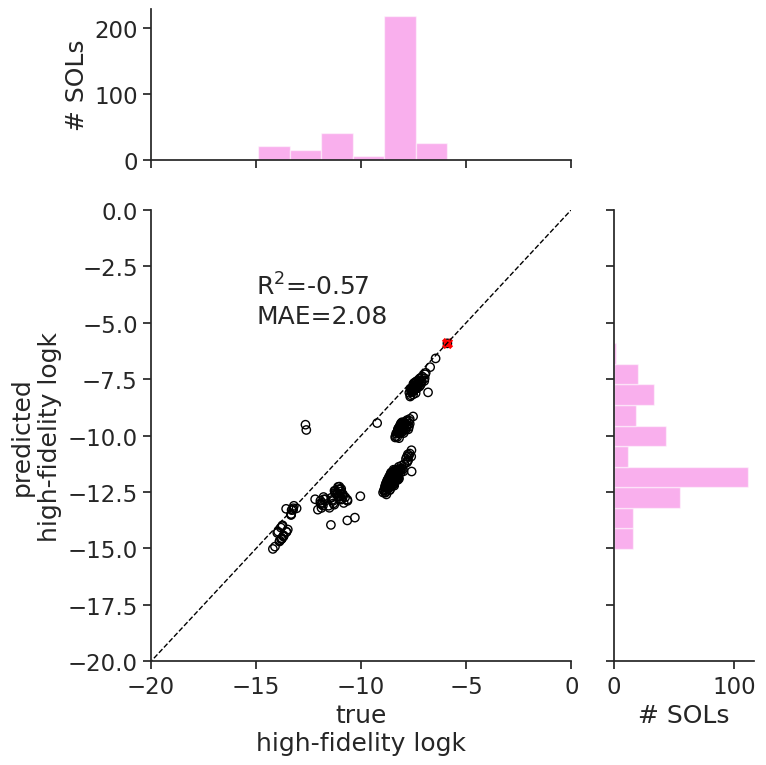

In [18]:
###
#  parity plot
###
gridspec_kw={'width_ratios': [6, 2], 'height_ratios': [2, 6]} # set ratios
fig, ax = plt.subplots(nrows=2, ncols=2, gridspec_kw=gridspec_kw, figsize=(8, 8))
# fig = plt.figure()
ax[0, 1].axis("off")
ax[1, 0].plot([-100, 100], [-100, 100], linestyle="--", color="k", linewidth=1)
# ax = plt.gca()
ax[1, 0].set_xlim(-20, 0)
ax[1, 0].set_ylim(-20, 0)

#ax[1, 0].set_aspect("equal", "box")

ax[1, 0].text(-15, -5, "R$^2$=%.2f\nMAE=%.2f" % (r2, abserr))
ax[1, 0].scatter(y_true, y_pred, fc='none', ec="k")
ax[1, 0].set_xlabel("true\nhigh-fidelity logk")
ax[1, 0].set_ylabel("predicted\nhigh-fidelity logk")
# plot acquired COF
ax[1, 0].scatter(y_true[id_in_test_sols_of_opt_sol], y_pred[id_in_test_sols_of_opt_sol], marker="x", color="red")


###
#  histogram of logk
###
hist_color = sns.color_palette("husl", 8)[7]
ax[0, 0].hist(y_true, color=hist_color, alpha=0.5) #
ax[0, 0].sharex(ax[1, 0])
ax[0, 0].set_ylabel('# SOLs')
plt.setp(ax[0, 0].get_xticklabels(), visible=False) # remove yticklabels

hist_color = sns.color_palette("husl", 8)[7]
ax[1, 1].hist(y_pred, color=hist_color, alpha=0.5, orientation="horizontal") #
ax[1, 1].sharey(ax[1, 0])
ax[1, 1].set_xlabel('# SOLs')
plt.setp(ax[1, 1].get_yticklabels(), visible=False) # remove yticklabels

sns.despine()
plt.tight_layout()
plt.show()

In [19]:
rf = RandomForestRegressor()
rf.fit(X_train[:, :7], y_train)
rf.score(X_test, y_true)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


0.7925620949158843

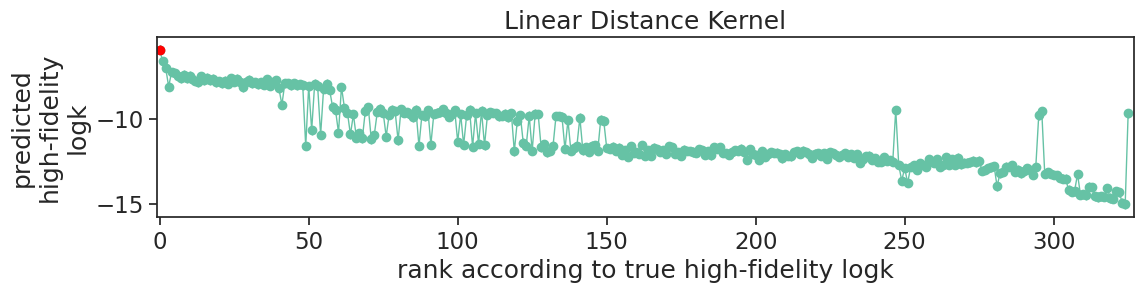

In [20]:
ids_sorted = np.argsort(y_true)[::-1]

plt.figure(figsize=(12, 3))
plt.errorbar(range(len(y_true)), y_pred[ids_sorted], yerr=sigma, linewidth=1, marker="o")
plt.errorbar(0, y_pred[id_in_test_sols_of_opt_sol], yerr=sigma[id_in_test_sols_of_opt_sol], linewidth=1, marker="o", color="red")
plt.xlabel("rank according to true high-fidelity logk")
plt.ylabel("predicted\nhigh-fidelity\nlogk")
plt.xlim(-1, len(test_sol_ids) +1)
plt.tight_layout()
plt.title('Linear Distance Kernel')
plt.show()

In [21]:
np.where([sol_id == sol_id_with_max_hi_fid_logk for sol_id in test_sol_ids])

(array([325]),)

# Trajectory plots

Streaming output truncated to the last 5000 lines.
  1.22120363e-244 0.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  7.26223631e-017 0.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000

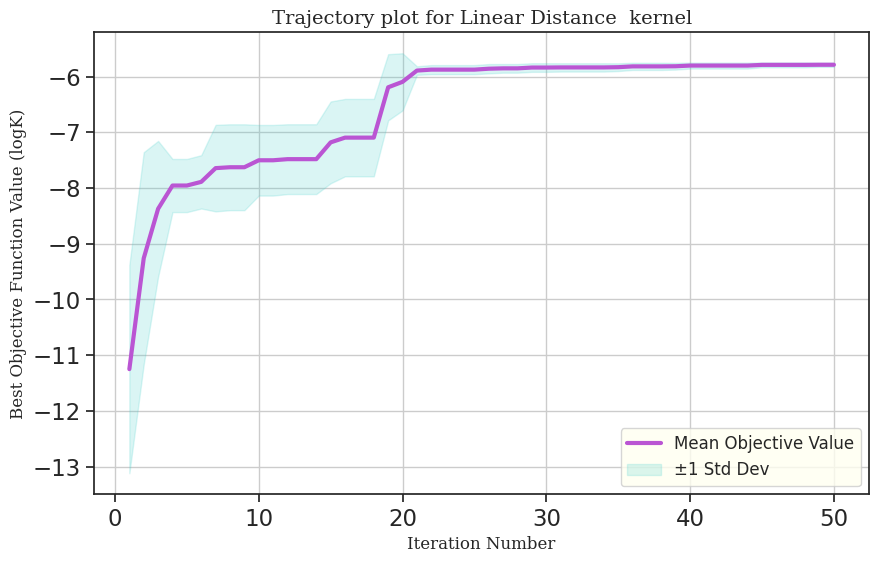

In [22]:
import numpy as np
import matplotlib.pyplot as plt

def run_one_optimization(nb_iterations, init_sol_ids, verbose=False):
    #run one BO
    acquired_set = run_Bayesian_optimization(nb_iterations, init_sol_ids, verbose=verbose)

    #Extract the objective function values (y_train)
    y_train = build_y_train(acquired_set).numpy().ravel()
    #build best so far matrix with the y_train values that improve
    best_so_far=[y_train[0]]
    for val in y_train[1:]:
        #We need the maximum:select the max of the last best, and the new value:
        best_so_far.append(max(best_so_far[-1], val))
    return best_so_far

def run_multiple_optimizations(num_runs, nb_iterations, nb_SOLs, nb_solvent, initialization='random'):
    #choose initialisation
    #fixed: uses same initial sols each run eg like in the first run
    #random: random solvents from the list
    all_runs_best = []
    for run_i in range(num_runs):
        if initialization == 'fixed':
            init_sol_ids = np.array(range(0, nb_solvent))
        else:
            #random init
            init_sol_ids = np.random.randint(0, nb_SOLs, size=nb_solvent)
        best_so_far = run_one_optimization(nb_iterations, init_sol_ids, verbose=False)

        #Ensure there is nb_sol values
        # If run_Bayesian_optimization stops early, pad with the last value
        if len(best_so_far)<nb_iterations:
            last_val=best_so_far[-1]
            best_so_far.extend([last_val]*(nb_iterations-len(best_so_far)))
        all_runs_best.append(best_so_far[:nb_iterations])
    #convert into a numpy array: shape (num_runs, nb_iterations)
    all_runs_best = np.array(all_runs_best)
    return all_runs_best
#average for the runs
def plot_mean_trajectory(all_runs_best):
    #mean and standard deviation
    mean_values = np.mean(all_runs_best, axis=0)
    std_values = np.std(all_runs_best, axis=0)
    nb_iterations = all_runs_best.shape[1]
    iterations = np.arange(1, nb_iterations + 1)
    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(iterations, mean_values, label='Mean Objective Value', color='mediumorchid')
    plt.fill_between(iterations, mean_values - std_values, mean_values + std_values,
                     color='mediumturquoise', alpha=0.2, label='±1 Std Dev')
    plt.xlabel("Iteration Number", fontsize=12, fontfamily='serif')
    plt.ylabel("Best Objective Function Value (logK)", fontsize=12, fontfamily='serif')
    plt.title("Trajectory plot for Linear Distance  kernel", fontsize=14, fontfamily='serif')
    plt.grid(True)
    plt.legend(fontsize=12, facecolor='ivory', loc='lower right')
    plt.show()

#test here:
#Budget is 50 evaluations, 100 for the random init
num_runs = 10
nb_iterations = 50
all_runs_best = run_multiple_optimizations(num_runs, nb_iterations, nb_SOLs, nb_solvent, initialization='random')
start_time    = time.time()
plot_mean_trajectory(all_runs_best)


In [23]:
print("y shape:", [y_.shape for y_ in y])
print("f_ids:", f_ids)


y shape: [torch.Size([335]), torch.Size([335])]
f_ids: [0.3333333432674408, 0.6666666865348816, 0.3333333432674408, 0.6666666865348816, 0.3333333432674408, 0.6666666865348816, 0.3333333432674408, 0.6666666865348816, 0.3333333432674408, 0.6666666865348816, 0.3333333432674408, 0.6666666865348816, 0.3333333432674408, 0.6666666865348816, 0.3333333432674408, 0.6666666865348816, 0.3333333432674408, 0.6666666865348816, 0.3333333432674408, 0.6666666865348816, 0.3333333432674408, 0.6666666865348816, 0.3333333432674408, 0.6666666865348816, 0.3333333432674408, 0.6666666865348816, 0.3333333432674408, 0.6666666865348816, 0.3333333432674408, 0.6666666865348816, 0.3333333432674408, 0.6666666865348816, 0.3333333432674408, 0.6666666865348816, 0.3333333432674408, 0.3333333432674408, 0.3333333432674408, 0.3333333432674408, 0.3333333432674408, 0.3333333432674408, 0.3333333432674408, 0.3333333432674408, 0.3333333432674408, 0.3333333432674408, 0.3333333432674408, 0.3333333432674408, 0.3333333432674408, 0.33